# 1. README

Please read the README.txt file to navigate this notebook.

# 2. Imports

In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from nltk import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.feature_selection import mutual_info_classif

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# 3. Preprocessing

## 3.1 Data Loading

In [2]:
# read in features/inputs (X)
train_features = pd.read_csv("train_features.csv")
valid_features = pd.read_csv("valid_features.csv")
test_features = pd.read_csv("test_features.csv")

# read in labels/output (y)
train_labels = pd.read_csv("train_labels.csv")
valid_labels = pd.read_csv("valid_labels.csv")

## 3.2 Defining X and y

In [3]:
# define X into three (3) parts:
# 1. Textual Features = Title, Lyric Tags
X_train_text = train_features.iloc[:,1:3].copy(deep=True)
X_valid_text = valid_features.iloc[:,1:3].copy(deep=True)
X_test_text = test_features.iloc[:,1:3].copy(deep=True)

# 2. Metadata Features = Loudness, Tempo, Time Signature, Key, Mode, Duration
X_train_meta = train_features.iloc[:,3:9].copy(deep=True)
X_valid_meta = valid_features.iloc[:,3:9].copy(deep=True)
X_test_meta = test_features.iloc[:,3:9].copy(deep=True)

# 3. Audio Features = 148 uninterpretable features
X_train_audio = train_features.iloc[:,9:].copy(deep=True)
X_valid_audio = valid_features.iloc[:,9:].copy(deep=True)
X_test_audio = test_features.iloc[:,9:].copy(deep=True)

In [4]:
# define y
# 1. Categorical values
y_train = train_labels.copy(deep=True)
y_valid = valid_labels.copy(deep=True)

# 2. Ordinal values
le = LabelEncoder().fit(y_train.iloc[:,1])
y_train_ordinal = le.transform(y_train.iloc[:,1])
y_valid_ordinal = le.transform(y_valid.iloc[:,1])

# 4. Data Exploration

## 4.1 Class Distributions

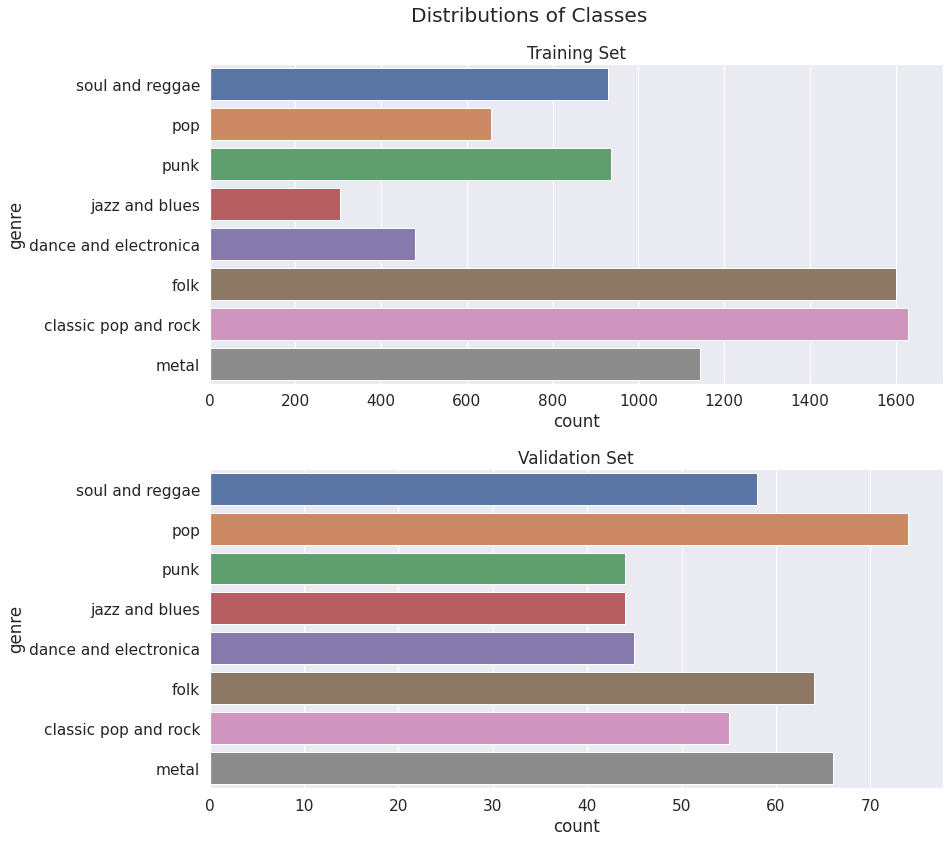

In [5]:
# class distribution for training and validation sets
sns.set(font_scale=1.4)

labels = ["soul and reggae",
          "pop",
          "punk",
          "jazz and blues",
          "dance and electronica",
          "folk",
          "classic pop and rock",
          "metal"]

# plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))
fig.suptitle('Distributions of Classes')

ax1 = sns.countplot(y='genre', data=y_train, ax=axes[0], order=labels)
axes[0].set_title("Training Set")
ax2 = sns.countplot(y='genre', data=y_valid, ax=axes[1], order=labels)
axes[1].set_title("Validation Set")

fig.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig("ClassDist.png")

## 4.2 Feature Distributions

### 4.2.1 Nominal Features

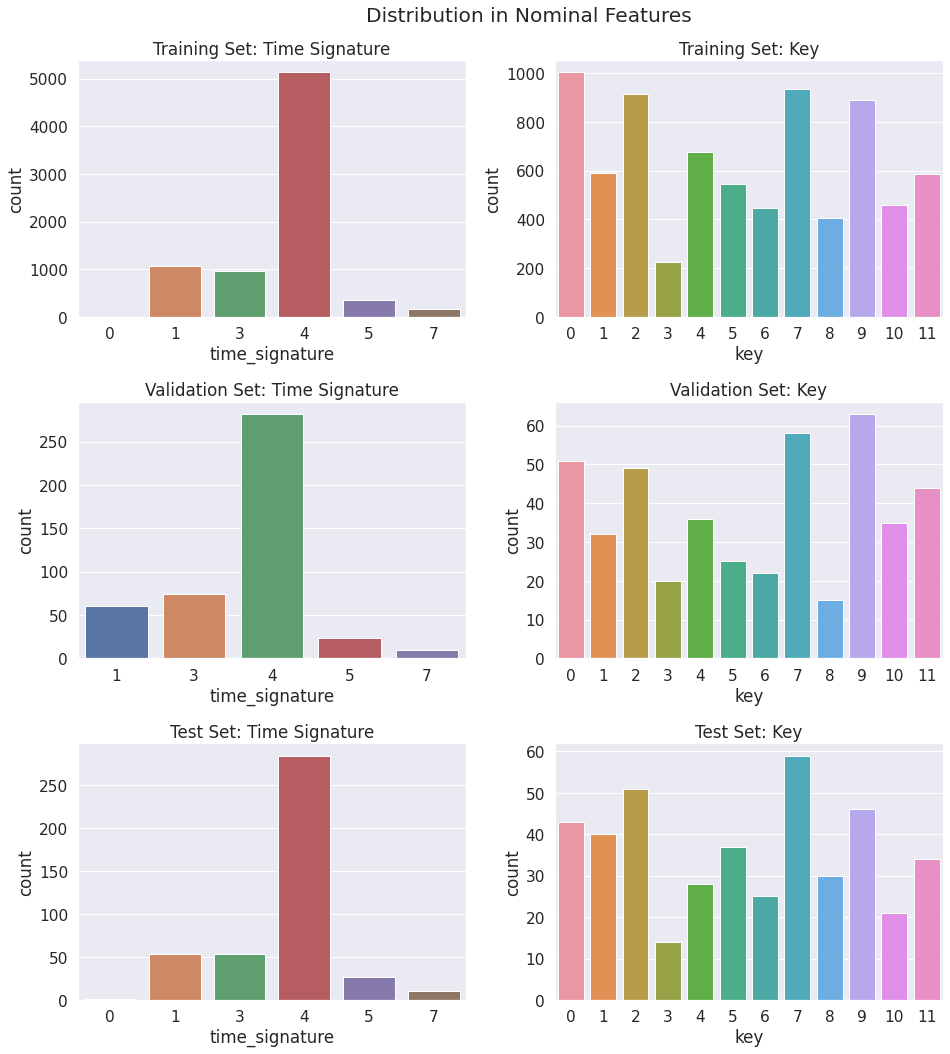

In [6]:
# how are the nominal features distributed in training and validation sets
sns.set(font_scale=1.4)

# plotting
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
fig.suptitle('Distribution in Nominal Features')

ax1 = sns.countplot(x='time_signature', data=X_train_meta, ax=axes[0][0])
axes[0][0].set_title("Training Set: Time Signature")
ax2 = sns.countplot(x='key', data=X_train_meta, ax=axes[0][1])
axes[0][1].set_title("Training Set: Key")

ax3 = sns.countplot(x='time_signature', data=X_valid_meta, ax=axes[1][0])
axes[1][0].set_title("Validation Set: Time Signature")
ax4 = sns.countplot(x='key', data=X_valid_meta, ax=axes[1][1])
axes[1][1].set_title("Validation Set: Key")

ax5 = sns.countplot(x='time_signature', data=X_test_meta, ax=axes[2][0])
axes[2][0].set_title("Test Set: Time Signature")
ax6 = sns.countplot(x='key', data=X_test_meta, ax=axes[2][1])
axes[2][1].set_title("Test Set: Key")


fig.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig("NomDist.png")

### 4.2.2 Continuous Features

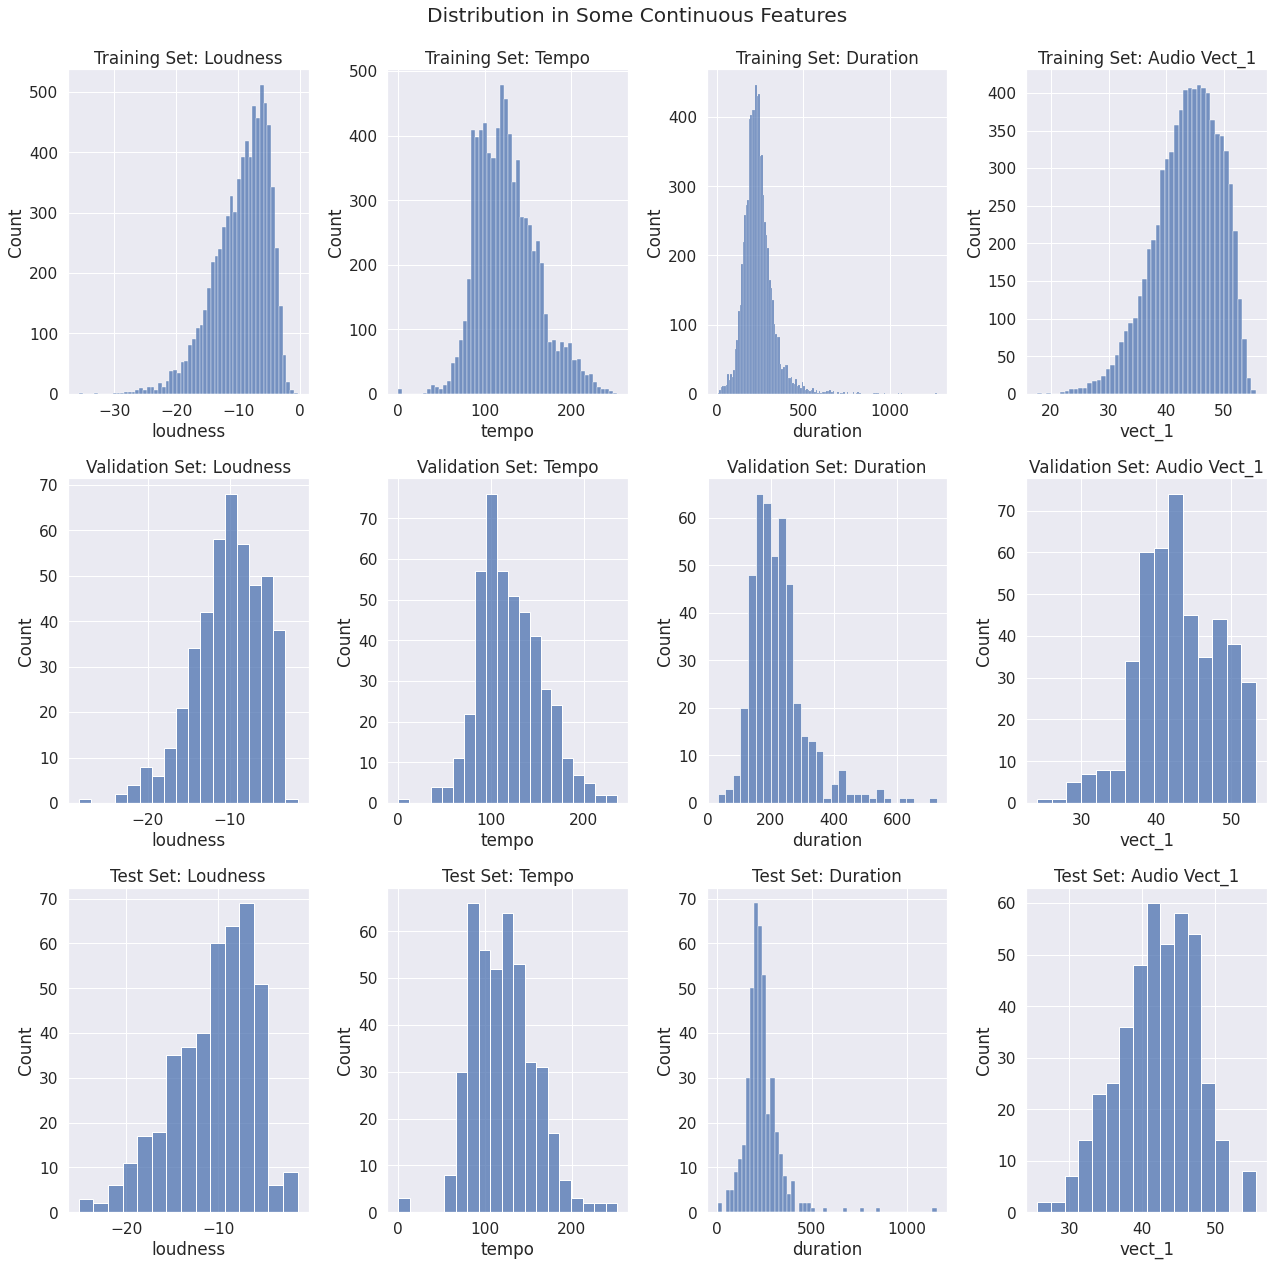

In [7]:
# how are the nominal features distributed in training and validation sets
sns.set(font_scale=1.4)

# plotting
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 18))
fig.suptitle('Distribution in Some Continuous Features')

ax1 = sns.histplot(x='loudness', data=X_train_meta, ax=axes[0][0])
axes[0][0].set_title("Training Set: Loudness")
ax2 = sns.histplot(x='tempo', data=X_train_meta, ax=axes[0][1])
axes[0][1].set_title("Training Set: Tempo")
ax3 = sns.histplot(x='duration', data=X_train_meta, ax=axes[0][2])
axes[0][2].set_title("Training Set: Duration")
ax4 = sns.histplot(x='vect_1', data=X_train_audio, ax=axes[0][3])
axes[0][3].set_title("Training Set: Audio Vect_1")

ax5 = sns.histplot(x='loudness', data=X_valid_meta, ax=axes[1][0])
axes[1][0].set_title("Validation Set: Loudness")
ax6 = sns.histplot(x='tempo', data=X_valid_meta, ax=axes[1][1])
axes[1][1].set_title("Validation Set: Tempo")
ax7 = sns.histplot(x='duration', data=X_valid_meta, ax=axes[1][2])
axes[1][2].set_title("Validation Set: Duration")
ax8 = sns.histplot(x='vect_1', data=X_valid_audio, ax=axes[1][3])
axes[1][3].set_title("Validation Set: Audio Vect_1")

ax9 = sns.histplot(x='loudness', data=X_test_meta, ax=axes[2][0])
axes[2][0].set_title("Test Set: Loudness")
ax10 = sns.histplot(x='tempo', data=X_test_meta, ax=axes[2][1])
axes[2][1].set_title("Test Set: Tempo")
ax11 = sns.histplot(x='duration', data=X_test_meta, ax=axes[2][2])
axes[2][2].set_title("Test Set: Duration")
ax12 = sns.histplot(x='vect_1', data=X_test_audio, ax=axes[2][3])
axes[2][3].set_title("Test Set: Audio Vect_1")


fig.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig("ContDist.png")

# 5. Feature Selection and Engineering

In [8]:
# selects which of the features with the highest MI statistic is best
def select_k_best(model, start, step, X_train, y_train, sorted_scores):
    # error rates
    er = []
    
    # features column names
    feature_names = X_train.columns
    
    for k in range(start, len(feature_names), step):
        # print("Simulating k=", k)
        # select top k scores and their corresponding column names
        topk_scores = sorted_scores[:k+1]
        topk_features = [feature_names[i] for i in topk_scores]
        
        # create new training set accordingly
        Xtrain = X_train[X_train.columns.intersection(topk_features)]
        
        # find accuracy using 5-fold cross validation on training set
        acc = np.mean(cross_val_score(clone(model), Xtrain, y_train, cv=StratifiedKFold(5)))
        
        # append error rate (= 1 - accuracy) to error rates
        er.append(1 - acc)

    # plotting
    plt.figure(figsize = (10, 6))
    plt.title('Feature Selection (MI): Error rate vs. Top K Features')
    plt.plot(np.arange(start+1, len(feature_names)+1, step),er, marker ='o',markerfacecolor ='yellow',markersize = 7)
    plt.xlabel('Top K')
    plt.ylabel('Error rate')
    filename = "FS_" + str(len(feature_names))
    plt.savefig(filename)
    
    return start + ((er.index(min(er)) + 1) * step) - 1

## 5.1 Textual Features

### 5.1.1 Feature Engineering with PorterStemmer and TfidfVectorizer

Steps:
1. Apply stemming to the Title
2. Concatenate Title and Lyric Tags
2. Drop unused columns
3. Fit a model that applies Term-Frequency Inverse-Distance Frequency (TFIDF) vectorization on all tokens (words) in training set
4. Apply transformation of this model on validation and test sets

In [9]:
# apply PorterStemmer to title
stemmer = PorterStemmer()
X_train_text['title'] = X_train_text['title'].apply(lambda x: ", ".join([stemmer.stem(w) for w in word_tokenize(x)]))
X_valid_text['title'] = X_valid_text['title'].apply(lambda x: ", ".join([stemmer.stem(w) for w in word_tokenize(x)]))
X_test_text['title'] = X_test_text['title'].apply(lambda x: ", ".join([stemmer.stem(w) for w in word_tokenize(x)]))

# concatenate title and tags
X_train_text['textual'] = X_train_text['title'] + ", " + X_train_text['tags']
X_valid_text['textual'] = X_valid_text['title'] + ", " + X_valid_text['tags']
X_test_text['textual'] = X_test_text['title'] + ", " + X_test_text['tags']

# drop unused columns
X_train_text = X_train_text.drop(['title','tags'], axis=1)
X_valid_text = X_valid_text.drop(['title','tags'], axis=1)
X_test_text = X_test_text.drop(['title','tags'], axis=1)

In [10]:
# apply tfidf vectorization
vectorizer = TfidfVectorizer()
X_train_text = pd.DataFrame(vectorizer.fit_transform(X_train_text.iloc[:,0]).todense())
X_valid_text = pd.DataFrame(vectorizer.transform(X_valid_text.iloc[:,0]).todense())
X_test_text = pd.DataFrame(vectorizer.transform(X_test_text.iloc[:,0]).todense())

### 5.1.2 Feature Selection with Mutual Information

Steps:
1. Find Mutual Information (MI) statistic for all text features
2. Sort text features by their statistic (descending order)
3. Screen away features that have an MI statistic less than or equal to 0.0001.
4. Re-organise the train/valid/test sets accordingly

In [11]:
# find mutual information statistic for all audio features
scores = mutual_info_classif(X_train_text, y_train_ordinal, random_state=101)

all_words = sorted(vectorizer.vocabulary_, key=vectorizer.vocabulary_.get)
all_words_sorted_scores = np.argsort(scores)

# find and print bottom 5 words in terms of MI which are to be removed
removals = [all_words[i] for i in all_words_sorted_scores[:5]]
print("Example of 5 words removed based on MI:", *removals)

# find and print top 5 words in terms of MI
top5 = [all_words[i] for i in all_words_sorted_scores[:-6:-1]]
print("Top 5 words based on MI:", *top5)

# how many features have MI<=0.0001
print("Number of Features with MI less than or equal to 0.0001:", np.sum(scores <= 0.0001))

sorted_scores = np.argsort(scores[np.where(scores > 0.0001)[0]])[::-1]

# remove these features with MI<=0.0001
X_train_text.drop(X_train_text.columns[np.where(scores <= 0.0001)[0]], axis=1, inplace=True)
X_valid_text.drop(X_valid_text.columns[np.where(scores <= 0.0001)[0]], axis=1, inplace=True)
X_test_text.drop(X_test_text.columns[np.where(scores <= 0.0001)[0]], axis=1, inplace=True)

Example of 5 words removed based on MI: 00 mama malon malo mall
Top 5 words based on MI: the to and love you
Number of Features with MI less than or equal to 0.0001: 3478


## 5.2 Metadata Features

### 5.2.1 Feature Selection with Correlation Coefficient

In [12]:
# get correlation coeffs with .corr()
correlated_features = set()
correlation_matrix = X_train_meta.corr()

# if any features have coef > 0.8, remove
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.80:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print("There are", len(correlated_features), "features with correlation greater than 0.80.")

There are 0 features with correlation greater than 0.80.


In [13]:
# drop correlated features
X_train_meta.drop(correlated_features, axis=1, inplace=True)

### 5.2.2 Feature Selection with Mutual Information

Steps:
1. Find Mutual Information (MI) statistic for all metadata features
2. Sort metadata features by their statistic (descending order)
3. Screen away features that have an MI statistic less than or equal to 0.0001.
4. Identify a good K for selecting the top K features
5. Re-organise the train/valid/test sets accordingly

In [14]:
# find mutual information statistic for all audio features
scores = mutual_info_classif(X_train_meta,
                             y_train_ordinal,
                             discrete_features=[2,3,4], # time_signature, key, mode are nominal/discrete
                             random_state=101)

# how many features have MI<=0.0001
print("Number of Features with MI less than or equal to 0.0001:", np.sum(scores <= 0.0001))

sorted_scores = np.argsort(scores[np.where(scores > 0.0001)[0]])[::-1]

# remove these features with MI<=0.0001
X_train_meta.drop(X_train_meta.columns[np.where(scores <= 0.0001)[0]], axis=1, inplace=True)
X_valid_meta.drop(X_valid_meta.columns[np.where(scores <= 0.0001)[0]], axis=1, inplace=True)
X_test_meta.drop(X_test_meta.columns[np.where(scores <= 0.0001)[0]], axis=1, inplace=True)

Number of Features with MI less than or equal to 0.0001: 0


Best K: 6


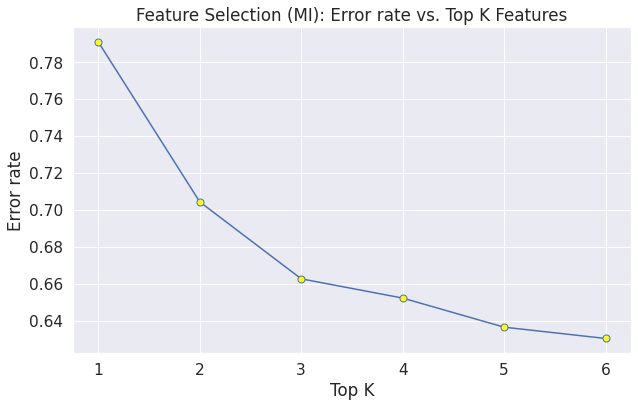

In [15]:
# features column names
feature_names = X_train_meta.columns

# find optimal number of features to select according to MI statistic
model = RandomForestClassifier(random_state=101)
start, step = 0, 1
optimal_k = select_k_best(model, start, step, X_train_meta, y_train.iloc[:,1], sorted_scores)
print("Best K:", optimal_k+1)

topk_scores = sorted_scores[:optimal_k+1]
topk_features = [feature_names[i] for i in topk_scores]

# redefine training, validation, and test sets accordingly
X_train_meta = X_train_meta[X_train_meta.columns.intersection(topk_features)]
X_valid_meta = X_valid_meta[X_valid_meta.columns.intersection(topk_features)]
X_test_meta = X_test_meta[X_test_meta.columns.intersection(topk_features)]

## 5.3 Audio Features

### 5.3.1 Feature Selection with Mutual Information

Steps:
1. Find Mutual Information (MI) statistic for all audio features
2. Sort audio features by their statistic (descending order)
3. Screen away features that have an MI statistic less than or equal to 0.0001.
4. Identify a good K for selecting the top K features
5. Re-organise the train/valid/test sets accordingly

In [16]:
# find mutual information statistic for all audio features
scores = mutual_info_classif(X_train_audio, y_train_ordinal, random_state=101)

# how many features have MI<=0.0001
print("Number of Features with MI less than or equal to 0.0001:", np.sum(scores <= 0.0001))

sorted_scores = np.argsort(scores[np.where(scores > 0.0001)[0]])[::-1]

# remove these features with MI<=0.0001
X_train_audio.drop(X_train_audio.columns[np.where(scores <= 0.0001)[0]], axis=1, inplace=True)
X_valid_audio.drop(X_valid_audio.columns[np.where(scores <= 0.0001)[0]], axis=1, inplace=True)
X_test_audio.drop(X_test_audio.columns[np.where(scores <= 0.0001)[0]], axis=1, inplace=True)

Number of Features with MI less than or equal to 0.0001: 0


Best K: 147


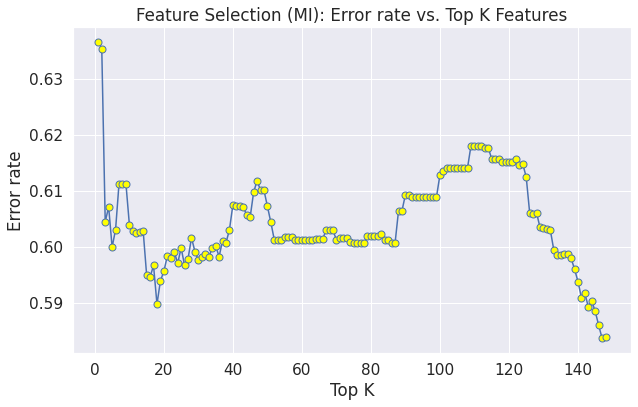

In [17]:
# features column names
feature_names = X_train_audio.columns

# find optimal number of features to select according to MI statistic
model = GaussianNB()
start, step = 0, 1
optimal_k = select_k_best(model, start, step, X_train_audio, y_train.iloc[:,1], sorted_scores)
print("Best K:", optimal_k+1)

topk_scores = sorted_scores[:optimal_k+1]
topk_features = [feature_names[i] for i in topk_scores]

# redefine training, validation, and test sets accordingly
X_train_audio = X_train_audio[X_train_audio.columns.intersection(topk_features)]
X_valid_audio = X_valid_audio[X_valid_audio.columns.intersection(topk_features)]
X_test_audio = X_test_audio[X_test_audio.columns.intersection(topk_features)]

## 5.4 Coming Together

In [18]:
# join feature subsets to make one feature set for training, validation, and test sets
X_train = X_train_text.join(X_train_meta).join(X_train_audio)
X_valid = X_valid_text.join(X_valid_meta).join(X_valid_audio)
X_test = X_test_text.join(X_test_meta).join(X_test_audio)

# 6. Train, Predict and Evaluate Classifiers

## Train

In [19]:
# trains a given classification model
def train(model, X_train, y_train):
    # train on training set
    trained_clf = clone(model).fit(X_train, y_train)

    return model, trained_clf

## Predict

In [20]:
# predicts each of the given trained classifiers
def predict(trained_clf, X_train, X_valid, y_train):
    # do 2-fold cross validation on training set
    y_cross_accs = cross_val_score(trained_clf[0], X_train, y_train, cv=StratifiedKFold(2))
    
    # predict for accuracy on training set
    y_pred_train = trained_clf[1].predict(X_train)
    
    # predict for accuracy on validation set
    y_pred_valid = trained_clf[1].predict(X_valid)
    
    return y_cross_accs, y_pred_train, y_pred_valid

## Evaluate

In [21]:
# evaluates each of the given predicted classifiers
def evaluate(y_preds, X_train, X_valid, y_train, y_valid):
    # 2-fold cross validation accuracy on training set
    acc_train = np.mean(y_preds[0])
    print("Training Set: 2-Fold Cross Validation Accuracy:", acc_train)
    
    # class-based average accuracy on training set
    cm_class_train = confusion_matrix(y_train, y_preds[1],normalize='true')
    acc_class_train = np.mean(cm_class_train.diagonal()) # diag are accuracies of each class
    print("Training Set: Class-Based Average Accuracy:", acc_class_train)
    
    # macro-f1-score on training set
    f1_train = f1_score(y_train, y_preds[1], average='macro', zero_division=1)
    print("Training Set: Macro-F1-Score:", f1_train)
    
    # accuracy on validation set
    acc_valid = accuracy_score(y_preds[2], y_valid)
    print("Validation Set: Accuracy:", acc_valid)
    
    # class-based average accuracy on validation set
    cm_class_valid = confusion_matrix(y_valid, y_preds[2], normalize='true')
    acc_class_valid = np.mean(cm_class_valid.diagonal()) # diag are accuracies of each class
    print("Validation Set: Class-Based Average Accuracy:", acc_class_valid)
    
    # macro-f1-score on validation set
    f1_valid = f1_score(y_valid, y_preds[2], average='macro', zero_division=1)
    print("Validation Set: Macro-F1-Score:", f1_valid)
    
    return [acc_train, acc_class_train, f1_train, acc_valid, acc_class_valid, f1_valid]

## 6.1 Baseline (Zero-R)

In [22]:
# train
zero_r = DummyClassifier(strategy='most_frequent')
trained_zero_r = train(zero_r, X_train, y_train.iloc[:,1])

# predict
predicted_zero_r = predict(trained_zero_r, X_train, X_valid, y_train.iloc[:,1])

# evaluate
metrics_zero_r = evaluate(predicted_zero_r, X_train, X_valid, y_train.iloc[:,1], y_valid.iloc[:,1])

Training Set: 2-Fold Cross Validation Accuracy: 0.2121646262047408
Training Set: Class-Based Average Accuracy: 0.125
Training Set: Macro-F1-Score: 0.043757386913076186
Validation Set: Accuracy: 0.12222222222222222
Validation Set: Class-Based Average Accuracy: 0.125
Validation Set: Macro-F1-Score: 0.027227722772277228


## 6.2 Benchmark (Decision Tree)

In [23]:
# train
dt = DecisionTreeClassifier(random_state=101)
trained_dt = train(dt, X_train, y_train.iloc[:,1])

# predict
predicted_dt = predict(trained_dt, X_train, X_valid, y_train.iloc[:,1])

# evaluate
metrics_dt = evaluate(predicted_dt, X_train, X_valid, y_train.iloc[:,1], y_valid.iloc[:,1])

Training Set: 2-Fold Cross Validation Accuracy: 0.4610575670747591
Training Set: Class-Based Average Accuracy: 1.0
Training Set: Macro-F1-Score: 1.0
Validation Set: Accuracy: 0.4311111111111111
Validation Set: Class-Based Average Accuracy: 0.4091378346900976
Validation Set: Macro-F1-Score: 0.4166174100378803


## 6.3 Standalone Models

### 6.3.1 Gaussian Naive Bayes Classifier

In [24]:
# train
gnb = GaussianNB()
trained_gnb = train(gnb, X_train, y_train.iloc[:,1])

# predict
predicted_gnb = predict(trained_gnb, X_train, X_valid, y_train.iloc[:,1])

# evaluate
metrics_gnb = evaluate(predicted_gnb, X_train, X_valid, y_train.iloc[:,1], y_valid.iloc[:,1])

Training Set: 2-Fold Cross Validation Accuracy: 0.5082052617869237
Training Set: Class-Based Average Accuracy: 0.5531291608569568
Training Set: Macro-F1-Score: 0.5345254195045763
Validation Set: Accuracy: 0.6488888888888888
Validation Set: Class-Based Average Accuracy: 0.6135054566223748
Validation Set: Macro-F1-Score: 0.6095719265625682


### 6.3.2 Random Forest Classifier

In [25]:
# train
rf = RandomForestClassifier(random_state=101)
trained_rf = train(rf, X_train, y_train.iloc[:,1])

# predict
predicted_rf = predict(trained_rf, X_train, X_valid, y_train.iloc[:,1])

# evaluate
metrics_rf = evaluate(predicted_rf, X_train, X_valid, y_train.iloc[:,1], y_valid.iloc[:,1])

Training Set: 2-Fold Cross Validation Accuracy: 0.5931232091690544
Training Set: Class-Based Average Accuracy: 1.0
Training Set: Macro-F1-Score: 1.0
Validation Set: Accuracy: 0.6377777777777778
Validation Set: Class-Based Average Accuracy: 0.5918622641548288
Validation Set: Macro-F1-Score: 0.5647588288722013


### 6.3.3 Logistic Regression Classifier

In [26]:
# train
lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
trained_lr = train(lr, X_train, y_train.iloc[:,1])

# predict
predicted_lr = predict(trained_lr, X_train, X_valid, y_train.iloc[:,1])

# evaluate
metrics_lr = evaluate(predicted_lr, X_train, X_valid, y_train.iloc[:,1], y_valid.iloc[:,1])

Training Set: 2-Fold Cross Validation Accuracy: 0.5573065902578797
Training Set: Class-Based Average Accuracy: 1.0
Training Set: Macro-F1-Score: 1.0
Validation Set: Accuracy: 0.5444444444444444
Validation Set: Class-Based Average Accuracy: 0.5114971174642511
Validation Set: Macro-F1-Score: 0.5048308235139761


### 6.3.4 Multilayer Perceptron Classifier

In [27]:
# train
mlp = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(100,50),
                                                    max_iter=1000,
                                                    activation='logistic'))
trained_mlp = train(mlp, X_train, y_train.iloc[:,1])

# predict
predicted_mlp = predict(trained_mlp, X_train, X_valid, y_train.iloc[:,1])

# evaluate
metrics_mlp = evaluate(predicted_mlp, X_train, X_valid, y_train.iloc[:,1], y_valid.iloc[:,1])

Training Set: 2-Fold Cross Validation Accuracy: 0.5336025006512113
Training Set: Class-Based Average Accuracy: 1.0
Training Set: Macro-F1-Score: 1.0
Validation Set: Accuracy: 0.5688888888888889
Validation Set: Class-Based Average Accuracy: 0.5335348806388677
Validation Set: Macro-F1-Score: 0.5228384970292046


## 6.4 Ensemble Stacking

In [28]:
# define the base models
level0 = list()
level0.append(('lr', make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))))
level0.append(('mlp', make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(100,50),
                                                                    max_iter=1000,
                                                                    activation='logistic'))))
level0.append(('rfc', RandomForestClassifier(random_state=101)))
level0.append(('gnb', GaussianNB()))

# define meta learner model
level1 = LogisticRegression(max_iter=1000)

# train
ens = StackingClassifier(estimators=level0, final_estimator=level1, cv=StratifiedKFold(2))
trained_ens = train(ens, X_train, y_train.iloc[:,1])

# predict
predicted_ens = predict(trained_ens, X_train, X_valid, y_train.iloc[:,1])

# evaluate
metrics_ens = evaluate(predicted_ens, X_train, X_valid, y_train.iloc[:,1], y_valid.iloc[:,1])

Training Set: 2-Fold Cross Validation Accuracy: 0.6351914561083616
Training Set: Class-Based Average Accuracy: 1.0
Training Set: Macro-F1-Score: 1.0
Validation Set: Accuracy: 0.6733333333333333
Validation Set: Class-Based Average Accuracy: 0.6390530567793499
Validation Set: Macro-F1-Score: 0.6217269141815212


### 6.4.1 Prepare Test Set Predictions

In [29]:
# # get trained classifier
# my_clf = trained_ens[1]

# # organise dataframe for csv extraction
# y_test = test_features.iloc[:,:1]

# # predict on test set
# y_test['genre'] = my_clf.predict(X_test)

# # write to csv
# y_test.to_csv("out.csv",index=False)

# 7. Analysis of Results

## 7.1 Overview of Accuracies

In [31]:
# create new dataframe with accuracies for each classifier
X = [["O-R"] + list(metrics_zero_r),
     ["DT"] + list(metrics_dt),
     ["GNB"] + list(metrics_gnb),
     ["RF"] + list(metrics_rf),
     ["LR"] + list(metrics_lr),
     ["MLP"] + list(metrics_mlp),
     ["ENS"] + list(metrics_ens)]

# column names
testsets = ["Model",
            "TS- 2FCV",
            "TS- CB HO",
            "TS- MF1 HO",
            "VS- HO",
            "VS- CB HO",
            "VS- MF1 HO"]

# create df
accs = pd.DataFrame(X, columns=testsets)
accs

,Model,TS- 2FCV,TS- CB HO,TS- MF1 HO,VS- HO,VS- CB HO,VS- MF1 HO
0,O-R,0.212165,0.125000,0.043757,0.122222,0.125000,0.027228
1,DT,0.461058,1.000000,1.000000,0.431111,0.409138,0.416617
2,GNB,0.508205,0.553129,0.534525,0.648889,0.613505,0.609572
3,RF,0.593123,1.000000,1.000000,0.637778,0.591862,0.564759
4,LR,0.557307,1.000000,1.000000,0.544444,0.511497,0.504831
5,MLP,0.533603,1.000000,1.000000,0.568889,0.533535,0.522838
6,ENS,0.635191,1.000000,1.000000,0.673333,0.639053,0.621727


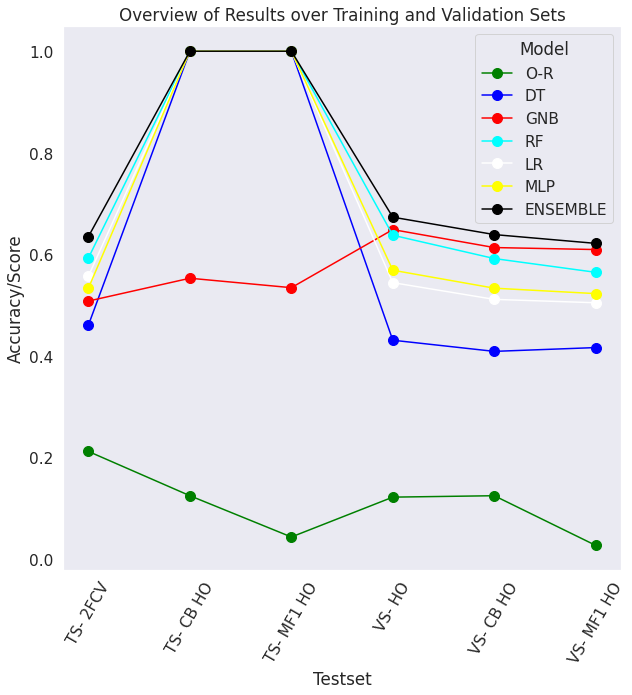

In [32]:
# plot graph to see performance of classifiers in relation to each other
fig = plt.figure(figsize=(10,10))

axes = plt.gca() # get current set of axes

# plotting
line_zero_r = plt.plot(testsets[1:],
                       accs.iloc[0,1:],
                       marker ='o',
                       markerfacecolor='green',
                       markersize = 10,
                       color='green')

line_dt = plt.plot(testsets[1:],
                   accs.iloc[1,1:],
                   marker ='o',
                   markerfacecolor='blue',
                   markersize = 10,
                   color='blue')

line_gnb = plt.plot(testsets[1:],
                    accs.iloc[2,1:],
                    marker ='o',
                    markerfacecolor='red',
                    markersize = 10,
                    color='red')

line_rf = plt.plot(testsets[1:],
                   accs.iloc[3,1:],
                   marker ='o',
                   markerfacecolor='cyan',
                   markersize = 10,
                   color='cyan')

line_lr = plt.plot(testsets[1:],
                   accs.iloc[4,1:],
                   marker ='o',
                   markerfacecolor='white',
                   markersize = 10,
                   color='white')

line_mlp = plt.plot(testsets[1:],
                    accs.iloc[5,1:],
                    marker ='o',
                    markerfacecolor='yellow',
                    markersize = 10,
                    color='yellow')

line_ens = plt.plot(testsets[1:],
                    accs.iloc[6,1:],
                    marker ='o',
                    markerfacecolor='black',
                    markersize = 10,
                    color='black')
# plotting configurations
plt.title("Overview of Results over Training and Validation Sets")
plt.xlabel("Testset")
plt.ylabel("Accuracy/Score")
plt.xticks(rotation=60)
plt.legend(["O-R", "DT", "GNB", "RF", "LR", "MLP", "ENSEMBLE"], title="Model", loc='upper right')
plt.grid(False)
plt.savefig("ResultsOverview.png")

## 7.2 Normalized Confusion Matrix on Class

Graphical representation of results in terms of classes

### 7.2.1 Baseline (Zero-R)

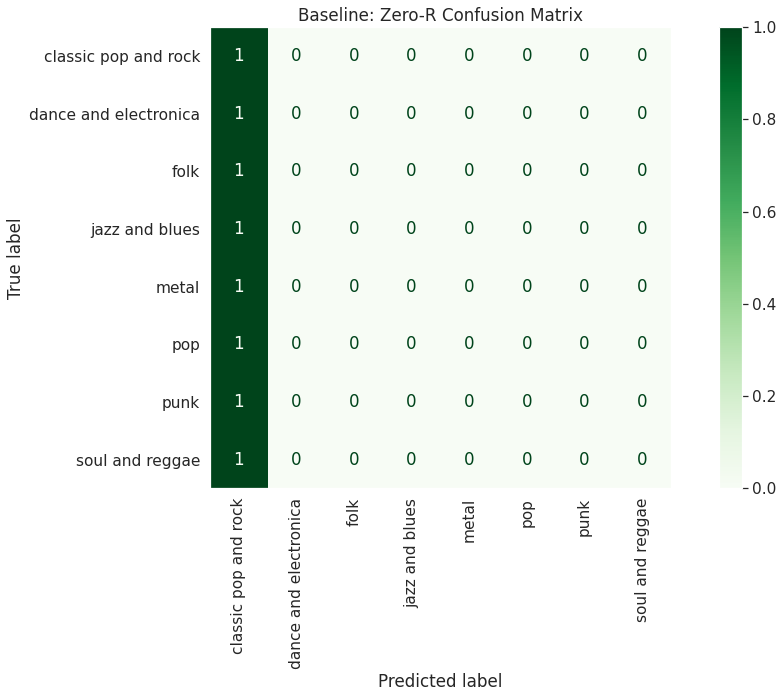

In [33]:
# zero_r confusion matrix
fig, axes = plt.subplots(figsize=(15,10))

# plotting
ax = plot_confusion_matrix(trained_zero_r[1],
                           X_valid,
                           y_valid.iloc[:,1],
                           display_labels=trained_zero_r[1].classes_,
                           cmap=plt.cm.Greens,
                           normalize='true',
                           xticks_rotation='vertical',
                           ax=axes)
axes.set_title("Baseline: Zero-R Confusion Matrix")
axes.grid(False)
fig.tight_layout(rect=[0, 0, 1, 1])
plt.savefig("Baseline_CM")

### 7.2.2 Benchmark (Decision Tree)

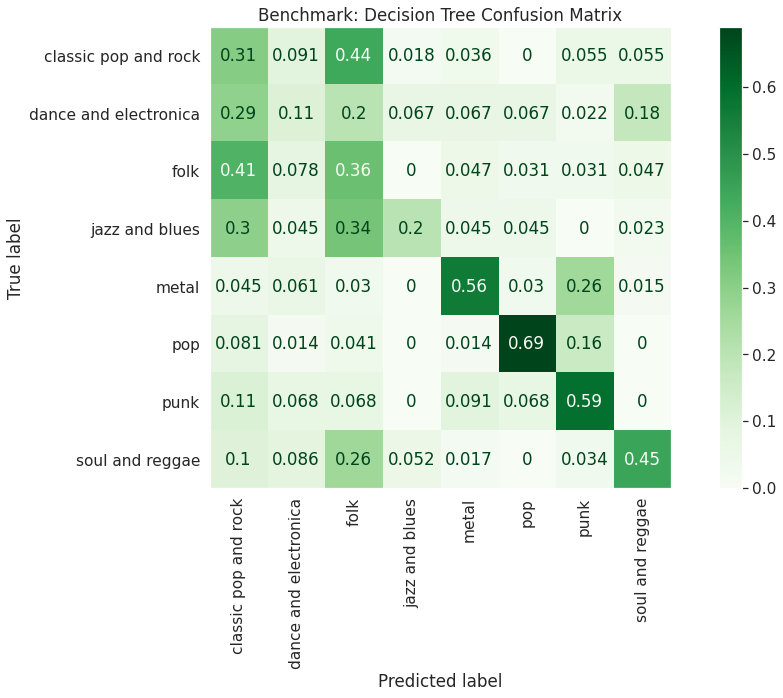

In [34]:
# dt confusion matrix
fig, axes = plt.subplots(figsize=(15,10))

# plotting
ax = plot_confusion_matrix(trained_dt[1],
                           X_valid,
                           y_valid.iloc[:,1],
                           display_labels=trained_dt[1].classes_,
                           cmap=plt.cm.Greens,
                           normalize='true',
                           xticks_rotation='vertical',
                           ax=axes)
axes.set_title("Benchmark: Decision Tree Confusion Matrix")
axes.grid(False)
fig.tight_layout(rect=[0, 0, 1, 1])
plt.savefig("Benchmark_CM")

### 7.2.3 Standalone Models

#### 7.2.3.1 Gaussian NB

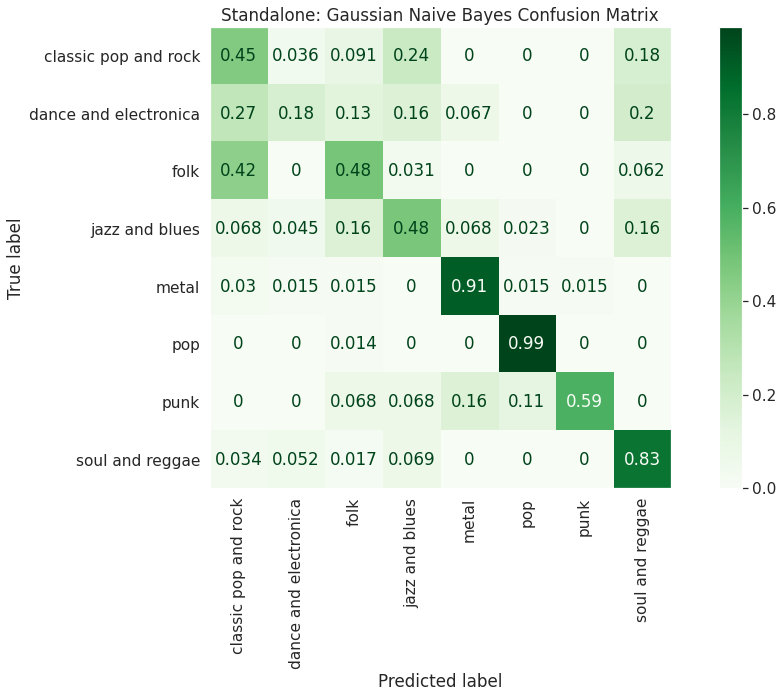

In [35]:
# gnb confusion matrix
fig, axes = plt.subplots(figsize=(15,10))

# plotting
ax = plot_confusion_matrix(trained_gnb[1],
                           X_valid,
                           y_valid.iloc[:,1],
                           display_labels=trained_gnb[1].classes_,
                           cmap=plt.cm.Greens,
                           normalize='true',
                           xticks_rotation='vertical',
                           ax=axes)
axes.set_title("Standalone: Gaussian Naive Bayes Confusion Matrix")
axes.grid(False)
fig.tight_layout(rect=[0, 0, 1, 1])
plt.savefig("GNB_CM")

#### 7.2.3.2 Random Forest

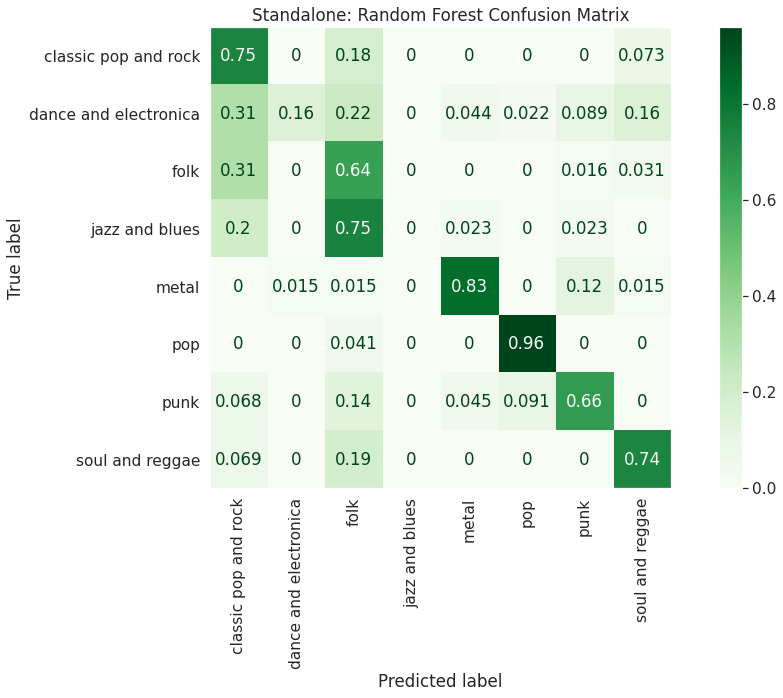

In [36]:
# rf confusion matrix
fig, axes = plt.subplots(figsize=(15,10))

# plotting
ax = plot_confusion_matrix(trained_rf[1],
                           X_valid,
                           y_valid.iloc[:,1],
                           display_labels=trained_rf[1].classes_,
                           cmap=plt.cm.Greens,
                           normalize='true',
                           xticks_rotation='vertical',
                           ax=axes)
axes.set_title("Standalone: Random Forest Confusion Matrix")
axes.grid(False)
fig.tight_layout(rect=[0, 0, 1, 1])
plt.savefig("RF_CM")

#### 7.2.3.3 Logistic Regression

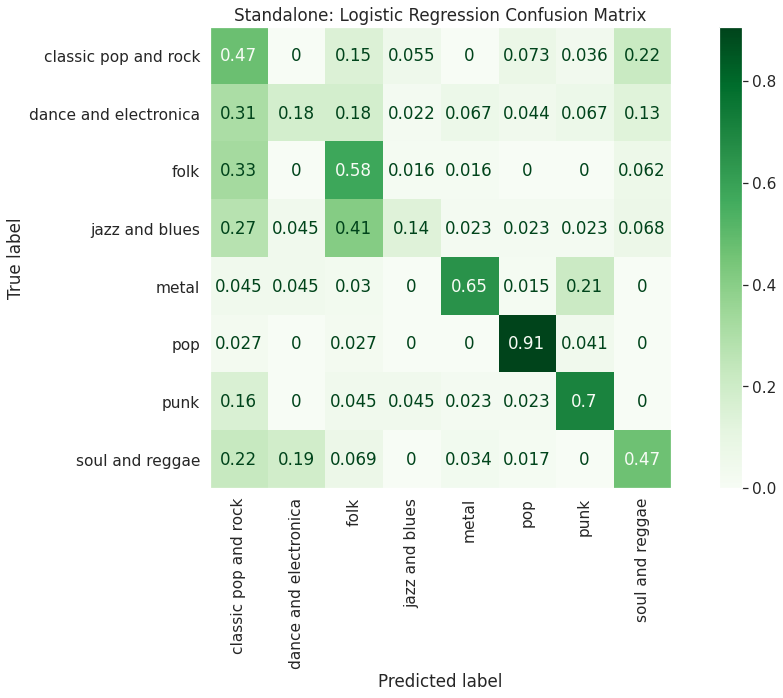

In [37]:
# lr confusion matrix
fig, axes = plt.subplots(figsize=(15,10))

# plotting
ax = plot_confusion_matrix(trained_lr[1],
                           X_valid,
                           y_valid.iloc[:,1],
                           display_labels=trained_rf[1].classes_,
                           cmap=plt.cm.Greens,
                           normalize='true',
                           xticks_rotation='vertical',
                           ax=axes)
axes.set_title("Standalone: Logistic Regression Confusion Matrix")
axes.grid(False)
fig.tight_layout(rect=[0, 0, 1, 1])
plt.savefig("LR_CM")

#### 7.2.3.4 Mutlilayer Perceptron

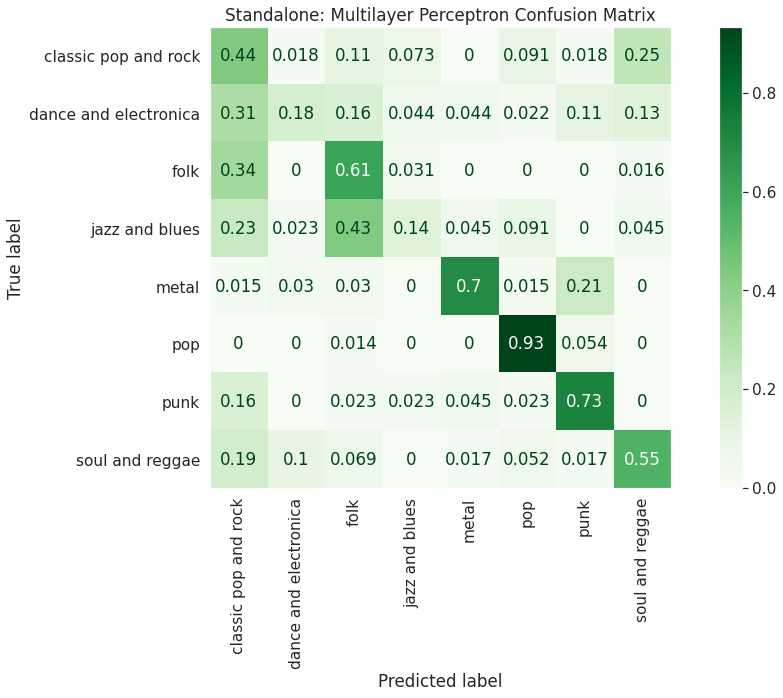

In [38]:
# mlp confusion matrix
fig, axes = plt.subplots(figsize=(15,10))

# plotting
ax = plot_confusion_matrix(trained_mlp[1],
                           X_valid,
                           y_valid.iloc[:,1],
                           display_labels=trained_rf[1].classes_,
                           cmap=plt.cm.Greens,
                           normalize='true',
                           xticks_rotation='vertical',
                           ax=axes)
axes.set_title("Standalone: Multilayer Perceptron Confusion Matrix")
axes.grid(False)
fig.tight_layout(rect=[0, 0, 1, 1])
plt.savefig("MLP_CM")

### 7.2.4 Ensemble Stacking

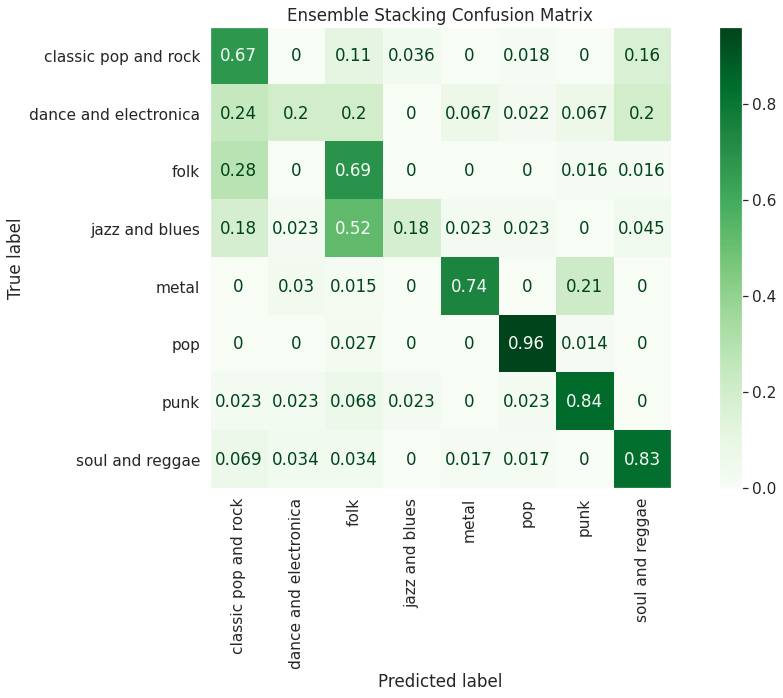

In [39]:
# ens confusion matrix
fig, axes = plt.subplots(figsize=(15,10))

# plotting
ax = plot_confusion_matrix(trained_ens[1],
                           X_valid,
                           y_valid.iloc[:,1],
                           display_labels=trained_rf[1].classes_,
                           cmap=plt.cm.Greens,
                           normalize='true',
                           xticks_rotation='vertical',
                           ax=axes)
axes.set_title("Ensemble Stacking Confusion Matrix")
axes.grid(False)
fig.tight_layout(rect=[0, 0, 1, 1])
plt.savefig("ENS_CM")